In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [3]:
df = pd.read_csv('titanic_dataset/train.csv') # read csv file as pandas data frame
df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [4]:
feature_name_list = list(df)
list(feature_name_list)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [5]:
df_selected = df[[ 'Pclass', 'Survived','Age', 'Sex', 'Parch']] # Choose desired features and labels(classes)
df_selected

,Pclass,Survived,Age,Sex,Parch
0,3,0,22.0,male,0
1,1,1,38.0,female,0
2,3,1,26.0,female,0
3,1,1,35.0,female,0
4,3,0,35.0,male,0
...,...,...,...,...,...
886,2,0,27.0,male,0
887,1,1,19.0,female,0
888,3,0,NaN,female,2
889,1,1,26.0,male,0


In [6]:
print('Total empty values in the Dataset :', df_selected.isnull().sum().sum())
clean_data = df_selected.dropna()
#print('Total empty values in the Dataset :', clean_data.isnull().sum().sum())

Total empty values in the Dataset : 177


In [7]:
for col in clean_data.columns:
        print('Unique values in {} :'.format(col),len(clean_data[col].unique()))

Unique values in Pclass : 3
Unique values in Survived : 2
Unique values in Age : 88
Unique values in Sex : 2
Unique values in Parch : 7


In [8]:
clean_data

,Pclass,Survived,Age,Sex,Parch
0,3,0,22.0,male,0
1,1,1,38.0,female,0
2,3,1,26.0,female,0
3,1,1,35.0,female,0
4,3,0,35.0,male,0
...,...,...,...,...,...
885,3,0,39.0,female,5
886,2,0,27.0,male,0
887,1,1,19.0,female,0
889,1,1,26.0,male,0


In [9]:
print('Unique values in updated Gender column :', clean_data.Sex.unique())
print('Range of column Age :', (clean_data.Age.min(), clean_data.Age.max()))
print('Unique values in parent/child column :', clean_data.Parch.unique())
print('Unique values in passenger class column :', clean_data.Pclass.unique())

clean_data['Sex'].replace(to_replace = 'male', value = 0, inplace=True)
clean_data['Sex'].replace(to_replace = 'female', value = 1, inplace=True)

Unique values in updated Gender column : ['male' 'female']
Range of column Age : (0.42, 80.0)
Unique values in parent/child column : [0 1 2 5 3 4 6]
Unique values in passenger class column : [3 1 2]


In [10]:
# Define features and labels (that contin class information)
test_ratio = 0.2
seed = 1430
np.random.seed(seed)

X = np.array(clean_data.drop('Survived', axis =1)) # X contains all feature values as array
y = np.array(clean_data.Survived) # y contains class values as array
X = preprocessing.normalize(X, axis=0)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed, stratify=y)

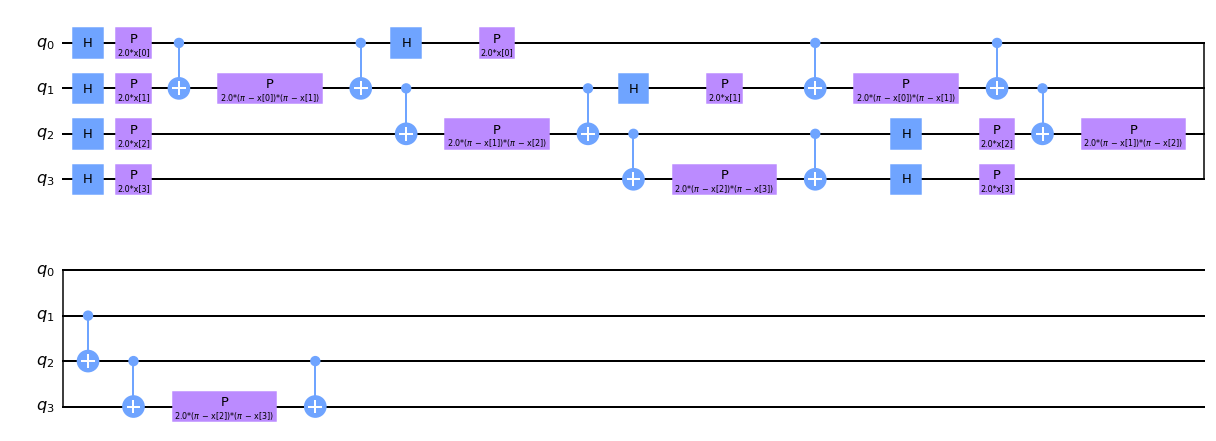

In [11]:
feature_dim = X.shape[1]
feature_map_rep = 2
ent = 'linear'

fmap_zz = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)
fmap_zz.decompose().draw('mpl', scale=1)

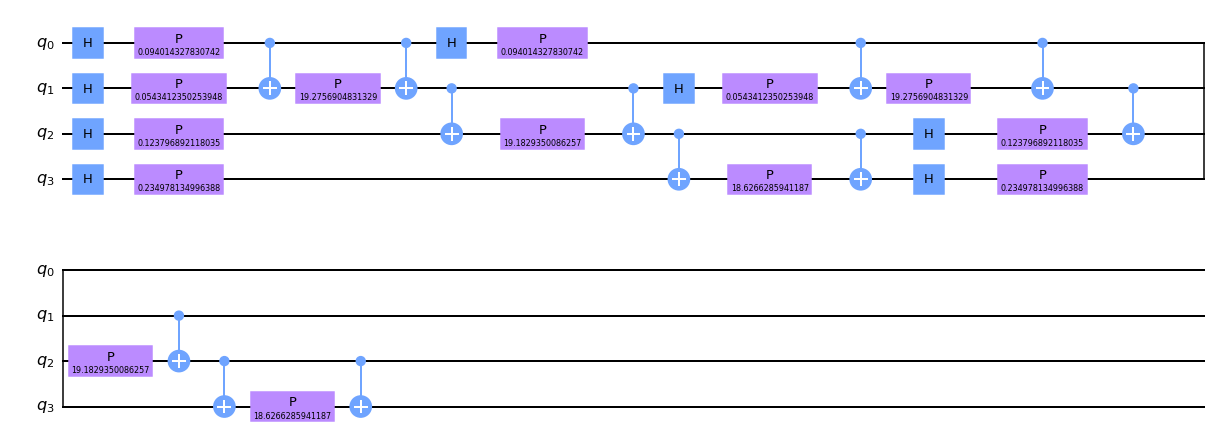

In [12]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

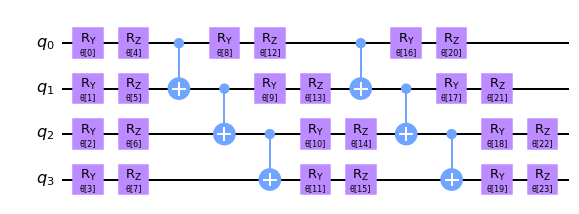

In [13]:
rotations = ['ry', 'rz']
var_form_rep = 2


ansatz_tl = TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)
ansatz_tl.decompose().draw('mpl', scale=1)

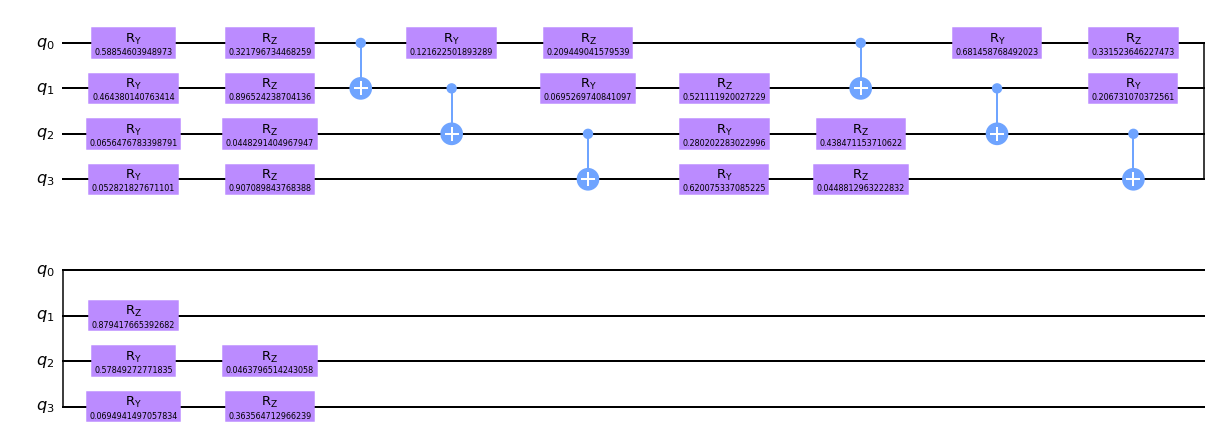

In [14]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=1)

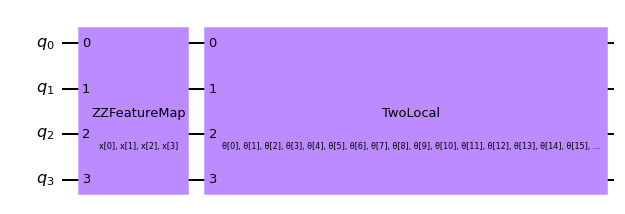

In [15]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl')

In [16]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [17]:
qasm_sim = Aer.get_backend('qasm_simulator')
qinst = QuantumInstance(qasm_sim, 4096)

In [18]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst,
                 )

In [19]:
# The result of the neural network of the shape (output_shape).
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.7019043, 0.2980957]])

In [20]:
# The result of the neural network of the backward pass, i.e., a tuple with the gradients
# for input and weights of shape (output_shape, num_input) and
# (output_shape, num_weights), respectively.
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.21191406, -0.00854492, -0.07373047, -0.00170898,
         -0.00036621,  0.01550293, -0.03869629, -0.00170898,
         -0.3145752 , -0.10388184, -0.00256348, -0.0057373 ,
          0.00183105,  0.00830078,  0.00854492,  0.00109863,
         -0.27941895,  0.00366211,  0.00219727,  0.00683594,
          0.00073242, -0.00305176,  0.00341797,  0.0012207 ],
        [ 0.21191406,  0.00854492,  0.07373047,  0.00170898,
          0.00036621, -0.01550293,  0.03869629,  0.00170898,
          0.3145752 ,  0.10388184,  0.00256348,  0.0057373 ,
         -0.00183105, -0.00830078, -0.00854492, -0.00109863,
          0.27941895, -0.00366211, -0.00219727, -0.00683594,
         -0.00073242,  0.00305176, -0.00341797, -0.0012207 ]]])

In [21]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [22]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [23]:
max_itr = 200
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point,
                              )


x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train])
x_test_norm = np.array([x/np.linalg.norm(x) for x in x_test])

vqc = vqc.fit(x_train_norm, y_train_1h)

3 - 625.3467323747545
6 - 790.4213550113905
9 - 694.1611704390941
12 - 555.4469470516069
15 - 550.767805357719
18 - 543.230005456837
21 - 542.2776039091132
24 - 538.05595341258
27 - 506.0616363497819
30 - 505.3065763749593
33 - 503.44338106742305
36 - 503.3601029272479
39 - 501.1374010091341
42 - 501.34675930142464
45 - 498.60930771223815
48 - 498.3900349559706
51 - 497.1213101440626
54 - 494.8886348945361
57 - 491.63502281923644
60 - 493.2948312301477
63 - 492.0486282145297
66 - 491.279124127521
69 - 478.8409596237909
72 - 477.0740773034512
75 - 477.238767760929
78 - 476.3351179166518
81 - 464.5250474603403
84 - 463.92612477418356
87 - 463.4511447304784
90 - 463.335681264278
93 - 461.7801876746402
96 - 458.8476806125012
99 - 457.6549445318959
102 - 457.41477676537687
105 - 457.3776316630026
108 - 456.9520106297141
111 - 453.9682874025085
114 - 454.2938483808443
117 - 454.7647548265306
120 - 452.5710571884887
123 - 454.16566970906774
126 - 453.32465586633975
129 - 452.9856046221642
132

In [24]:
score_train = vqc.score(x_train_norm, y_train_1h)
score_test = vqc.score(x_test_norm, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.7285464098073555
Score on the test set 0.7062937062937062


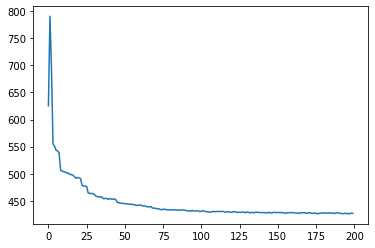

In [25]:
plt.plot(loss_recorder)